In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Sun - Short Time

In [2]:
npz = np.load('SunRun1final.npz')

In [3]:
volts = npz['volts']
time = npz['time']

In [5]:
time

array([  1.55200189e+09,   1.55200192e+09,   1.55200195e+09,
         1.55200198e+09,   1.55200201e+09,   1.55200204e+09,
         1.55200207e+09,   1.55200210e+09,   1.55200213e+09,
         1.55200216e+09,   1.55200219e+09,   1.55200222e+09,
         1.55200225e+09,   1.55200228e+09,   1.55200231e+09,
         1.55200234e+09,   1.55200237e+09,   1.55200240e+09,
         1.55200243e+09,   1.55200246e+09,   1.55200249e+09,
         1.55200252e+09,   1.55200255e+09,   1.55200258e+09,
         1.55200261e+09,   1.55200264e+09,   1.55200267e+09,
         1.55200270e+09,   1.55200273e+09,   1.55200276e+09,
         1.55200279e+09,   1.55200282e+09,   1.55200285e+09,
         1.55200288e+09,   1.55200291e+09,   1.55200294e+09,
         1.55200297e+09,   1.55200300e+09,   1.55200303e+09,
         1.55200306e+09,   1.55200309e+09,   1.55200312e+09,
         1.55200315e+09,   1.55200318e+09,   1.55200321e+09,
         1.55200324e+09,   1.55200327e+09,   1.55200330e+09,
         1.55200333e+09,

<IPython.core.display.Javascript object>


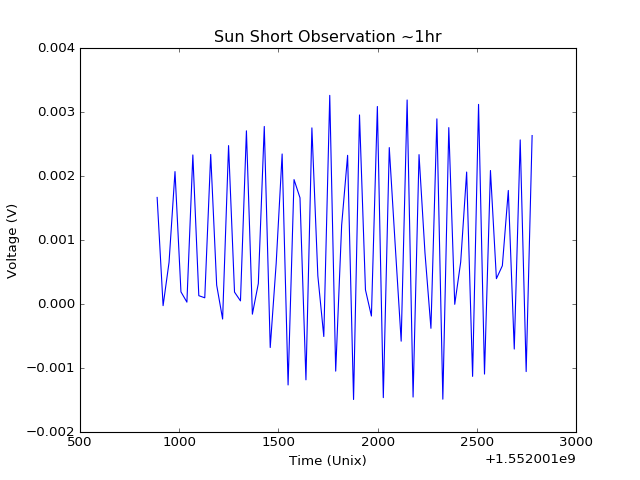

In [28]:
plt.plot(time, volts)
plt.title("Sun Short Observation ~1hr")
plt.xlabel("Time (Unix)")
plt.ylabel("Voltage (V)")
#plt.savefig('SunShortVolts.pdf', bbox_inches='tight')
plt.savefig('SunShortVolts.png')
plt.show()

In [6]:
sunft = np.abs(np.fft.fft(volts))**2
sunfreqs = np.fft.fftfreq(len(volts), 15)

<IPython.core.display.Javascript object>


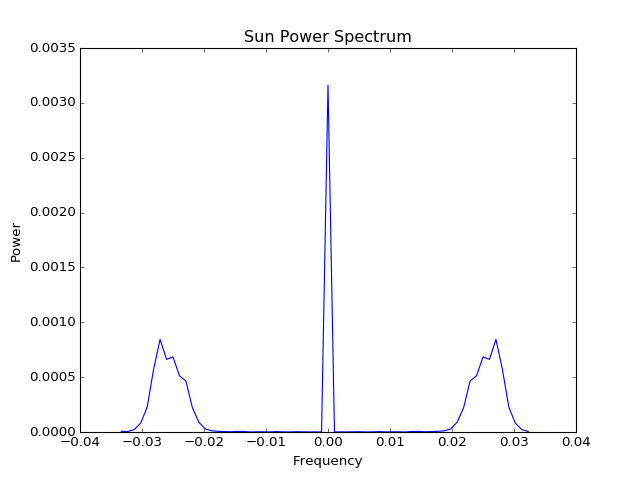

In [29]:
plt.plot(np.fft.fftshift(sunfreqs), np.fft.fftshift(sunft))
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("Sun Power Spectrum")
#plt.savefig('SunShortSpec.pdf', bbox_inches='tight')
plt.savefig('SunShortSpec.png')
plt.show()

## Crab Nebula

In [11]:
npz = np.load('Crab_Longfinal.npz')

In [12]:
crabvolts = npz['volts']
crabtimes = npz['time']

<IPython.core.display.Javascript object>


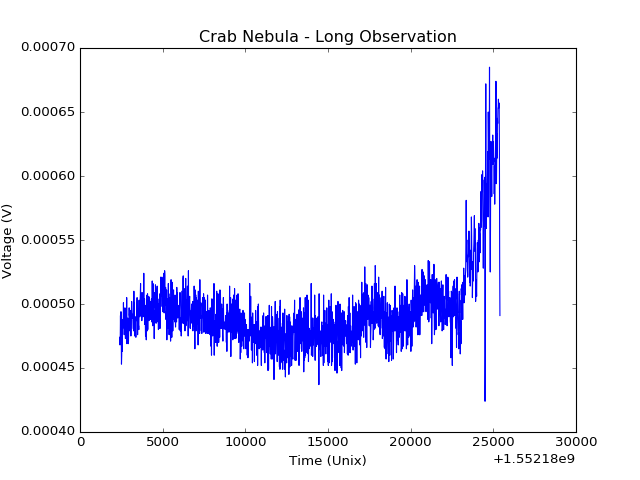

In [30]:
plt.plot(crabtimes, crabvolts)
plt.title("Crab Nebula - Long Observation")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (Unix)")
#plt.savefig('CrabVolts.pdf', bbox_inches='tight')
plt.savefig('CrabVolts.png')
plt.show()

In [15]:
crabft = np.abs(np.fft.fft(crabvolts))**2
crabfreqs = np.fft.fftfreq(len(crabvolts), 15)

<IPython.core.display.Javascript object>


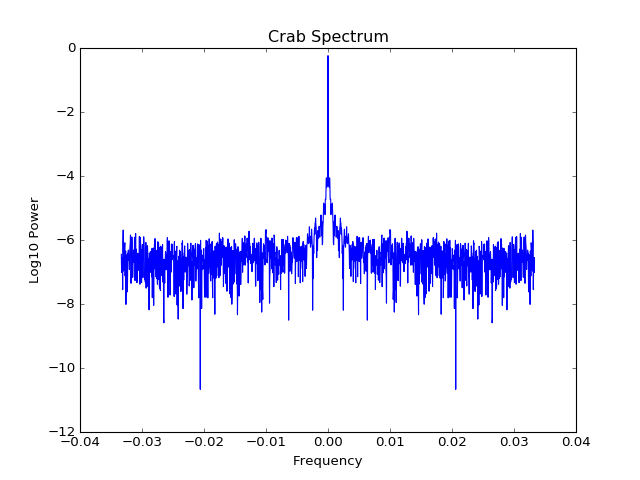

In [31]:
%matplotlib notebook
plt.plot(np.fft.fftshift(crabfreqs), np.log10(np.fft.fftshift(crabft)))
plt.title('Crab Spectrum')
plt.ylabel("Log10 Power")
plt.xlabel("Frequency")
#plt.savefig('CrabSpec.pdf', bbox_inches='tight')
plt.savefig('CrabSpec.png')
plt.show()

In [32]:
len(crabft)

1534

<IPython.core.display.Javascript object>


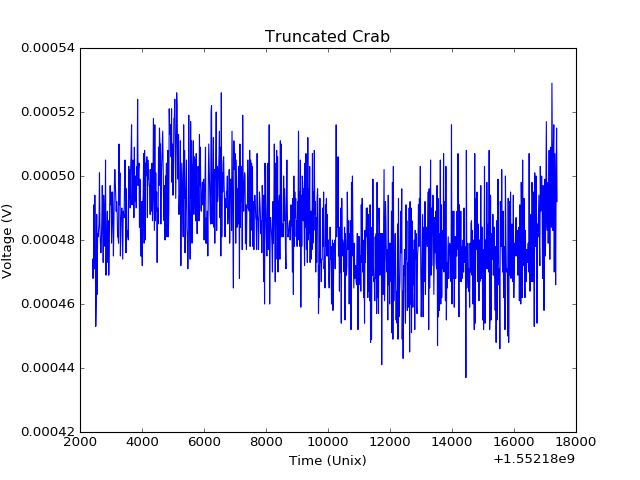

In [43]:
plt.plot(crabtimes[:1000], crabvolts[:1000])
plt.title('Truncated Crab')
plt.xlabel('Time (Unix)')
plt.ylabel('Voltage (V)')
plt.savefig('Trunkrab.png')
plt.show()

In [37]:
crabft1 = np.abs(np.fft.fft(crabvolts[0:1000]))**2
crabfreqs1 = np.fft.fftfreq(len(crabvolts[0:1000]), 15)

<IPython.core.display.Javascript object>


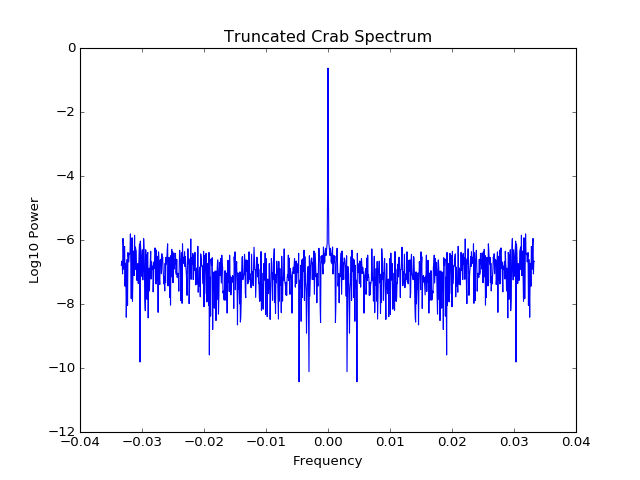

In [44]:
plt.plot(np.fft.fftshift(crabfreqs1), np.log10(np.fft.fftshift(crabft1)))
plt.title('Truncated Crab Spectrum')
plt.ylabel("Log10 Power")
plt.xlabel("Frequency")
#plt.savefig('CrabSpec.pdf', bbox_inches='tight')
plt.savefig('TrunkCrabSpec.png')
plt.show()